In [1]:
import sys
import os
home = os.environ['HOME']
sys.path.append(home + '/projects/turbubox/tools/lib')
sys.path.append(home + '/projects/turbubox/tools')

import numpy as np
import pandas as pd
import glob
import cubicle
import turbubox.ulz as ulz

import scipy.interpolate
import scipy.special as scp
from scipy.misc import factorial

import matplotlib
matplotlib.rcParams.update({'font.size': 9})

import matplotlib.pyplot as plt
%matplotlib inline
import gausslobatto

import scipy.signal

dpi = 100
fac = 0.5
geo = (fac*1920,fac*1080)

from numpy.fft import fftn, ifftn,fftshift

from mpl_toolkits.mplot3d import axes3d

from mpl_toolkits.axes_grid1 import make_axes_locatable

def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

In [2]:
def tile(carpet,ncells):
    return np.array([np.hsplit(row,ncells) for row in np.vsplit(carpet,ncells)])

def stitch(arr):
    return np.concatenate([np.concatenate(row,axis=1) for row in arr])

In [199]:
#fp = '/mnt/sshfs/supermuc2/gss/scratch/pr62su/ri97lab8/StirTurb_CGM_dense5_512/StirTurb_hdf5_plt_cnt_0013'
fp = '/mnt/data/couchdg/gravity-stabilization/data/chkpt_0020.h5'
#fp = '/home/jmark/tmp/crossroads/chkpt_0184.h5'
#fp = '/mnt/sshfs/cheops/scratch/jmarker2/couchdg/gravity/static/data/chkpt_0200.h5'
fh = cubicle.File(fp)
#fh.nodetype = 'gauss'
#fh.nodetype = 'cell-centered'
extent = fh.domain.T.ravel()
extent = np.roll(extent,2)

Nvisu = 5

#dens, velx, vely, velz, pres = fh.get_prims(Nvisu=None, imspace=gausslobatto.mk_nodes(fh.npoly,fh.nodetype))
dens, velx, vely, velz, pres = fh.get_prims(Nvisu=Nvisu)
#dens, velx, vely, velz, pres = fh.get_prims(Nvisu=14)

In [200]:
dens.shape

(240, 240)

In [362]:
ncells = 21
npoly = 7
Nvisu = npoly+1

nodes = gausslobatto.mk_nodes(npoly,ntype='gauss-lobatto')
#nodes = ulz.mk_body_centered_linspace(-1,1,Nvisu)

xs = ulz.mk_body_centered_linspace(0,1,ncells)
Xs,Ys = np.meshgrid(xs,xs)

MM = np.zeros_like(Xs)
MM += 0.001

#MM[len(MM)//2,len(MM)//2] = 0.8
#MM[2,2] = 0.5
#MM[-5,4] = 0.7

dens = ulz.zoom_array(MM,npoly+1)

domsize = (1,1)

In [363]:
dens.shape

(168, 168)

In [364]:
def mk_near_field(qs,rxs,rys,a,b,i,j,rr=0.1):
    dd = 1/np.sqrt((rxs-a)**2 + (rys-b)**2 + rr)
    f1 = (rxs-a)*dd**3
    f2 = (rys-b)*dd**3

    S11 = (3*dd**5*(rxs-a)**2 - dd**3)/2
    S22 = (3*dd**5*(rys-b)**2 - dd**3)/2
    S12 =  3*dd**5*(rxs-a)*(rys-b)
    
    T11 = (9*(rxs-a)*dd**5 - 15*(rxs-a)**3*dd**7)/6
    T22 = (9*(rys-b)*dd**5 - 15*(rys-b)**3*dd**7)/6
    T12 = (3*(rys-b)*dd**5 - 15*(rxs-a)**2*(rys-b)*dd**7)/2
    T21 = (3*(rxs-a)*dd**5 - 15*(rxs-a)*(rys-b)**2*dd**7)/2
    
    qs = np.ravel(qs)
    dd = np.ravel(dd)
    f1 = np.ravel(f1)
    f2 = np.ravel(f2)
    S11 = np.ravel(S11)
    S12 = np.ravel(S12)
    S22 = np.ravel(S22)
    T11 = np.ravel(T11)
    T12 = np.ravel(T12)
    T21 = np.ravel(T21)
    T22 = np.ravel(T22)

    def field(xs,ys):
        a1 = np.ravel(xs-a)
        b1 = np.ravel(ys-b)
        a2 = a1**2
        b2 = b1**2
        ab = a1*b1
        a3 = a1**3
        b3 = b1**3
        a2b = a2*b1
        ab2 = a1*b2

        return np.array([np.dot(qs,
            dd \
            + f1*a1[i] + f2*b1[i] \
            + S11*a2[i] + S12*ab[i] + S22*b2[i] \
            + T11*a3[i] + T12*a2b[i] + T21*ab2[i] + T22*b3[i]
        ) for i in range(len(a1))]).reshape(xs.shape)
    
        #return np.array([np.dot(qs, dd + f1*a1[i] + f2*b1[i] + S11*a2[i] + S12*ab[i] + S22*b2[i]) for i in range(len(a1))]).reshape(xs.shape)
    
        #return np.array([np.dot(qs, dd + f1*aa[i] + f2*bb[i]) for i in range(len(aa))]).reshape(xs.shape)
        #return np.array([np.dot(qs, dd) for i in range(len(aa))]).reshape(xs.shape)
    
    return field

In [370]:
ncells = dens.shape[0]//Nvisu
nodes  = ulz.mk_body_centered_linspace(-1,1,Nvisu)
nodes = gausslobatto.mk_nodes(Nvisu-1,ntype='gauss-lobatto')

r_min = 0.002

# cell points
cs      = ulz.mk_body_centered_linspace(0,1,ncells)
cxs,cys = np.meshgrid(cs,cs)

# grid points
xs = np.array([c + nodes / ncells / 2 for c in cs])
xs = np.ravel(xs)
gxs,gys = np.meshgrid(xs,xs)

Gxs = tile(gxs,ncells)
Gys = tile(gys,ncells)

# center masses
mqs = np.array([[np.sum(cell) for cell in rows] for rows in tile(dens    ,ncells)])
mxs = np.array([[np.sum(cell) for cell in rows] for rows in tile(dens*gxs,ncells)]) / (1e-16+mqs)
mys = np.array([[np.sum(cell) for cell in rows] for rows in tile(dens*gys,ncells)]) / (1e-16+mqs)

if 0:
    mqs = np.concatenate([np.concatenate([mqs]*3)]*3,axis=1)
    mxs = np.concatenate([np.concatenate([mxs-1,mxs,mxs+1],axis=1)]*3,axis=0)
    mys = np.concatenate([np.concatenate([mys-1,mys,mys+1],axis=0)]*3,axis=1)

def calc_pot(i,j):
    #dist = np.sqrt((cxs[i,j]-cxs)**2 + (cys[i,j]-cys)**2)
    #mqs_ = np.where(dist <= r_min, mqs, 0.0)
    mqs_ = -mqs
    fs   = mk_near_field(mqs_,mxs,mys,cxs[i,j],cys[i,j],i,j)(Gxs[i,j],Gys[i,j])

    return fs

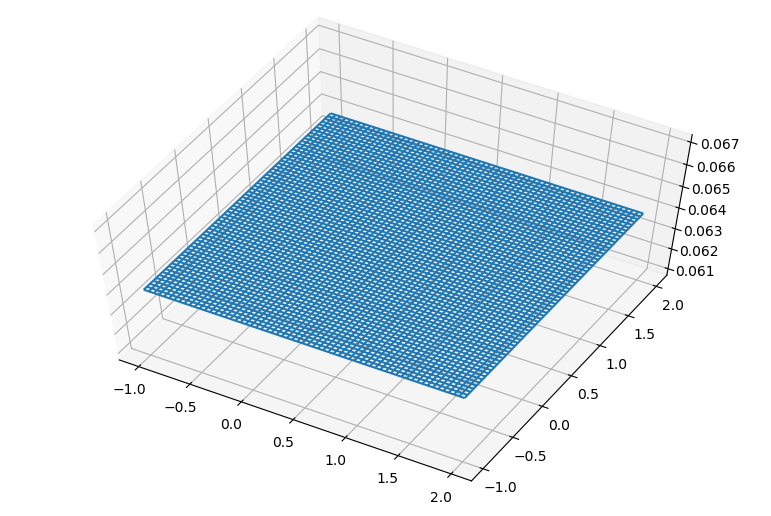

In [366]:
fig = plt.figure(1,figsize=(geo[0]/dpi, 1.2*geo[1]/dpi), dpi=dpi)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=60.)

stride = 1

xs = mxs
ys = mys
zs = mqs

ax.plot_wireframe(xs,ys,zs,rstride=stride,cstride=stride)

In [371]:
pot2 = pot

In [372]:
pot = np.array([[calc_pot(i,j) for j in range(ncells)] for i in range(ncells)])
pot.shape

(21, 21, 8, 8)

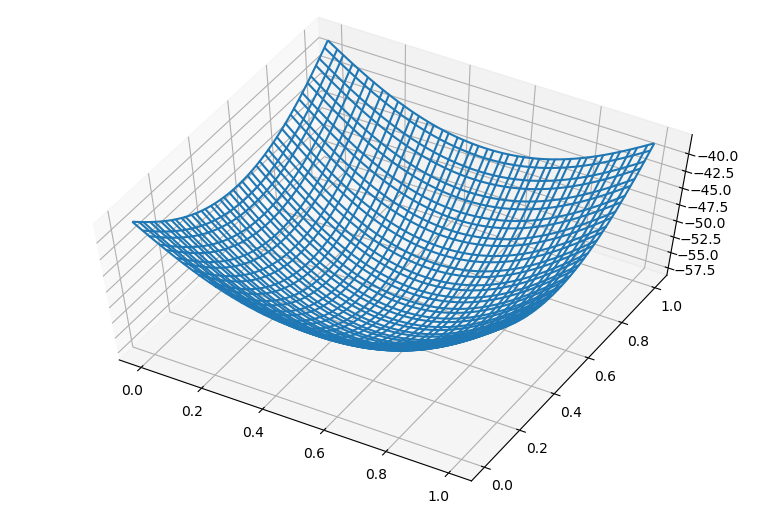

In [374]:
fig = plt.figure(1,figsize=(geo[0]/dpi, 1.2*geo[1]/dpi), dpi=dpi)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=60.)

stride = 4

xs = stitch(Gxs)
ys = stitch(Gys)
zs = stitch(pot)

ax.plot_wireframe(xs,ys,zs,rstride=stride,cstride=stride)

In [376]:
pot.shape

(21, 21, 8, 8)

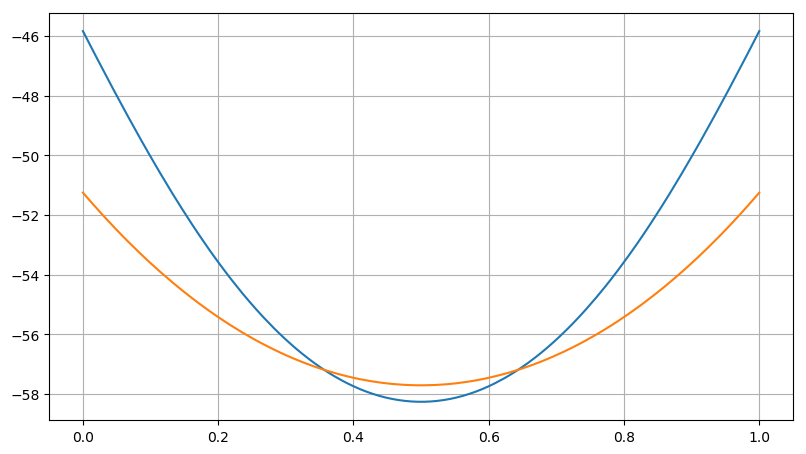

In [379]:
fig = plt.figure(1,figsize=(geo[0]/dpi, geo[1]/dpi), dpi=dpi)
plt.grid()

zs = stitch(pot)
plt.plot(ys[:,len(ys)//2],zs[:,len(zs)//2],'-')

zs = stitch(pot2) + 190
plt.plot(ys[:,len(ys)//2],zs[:,len(zs)//2],'-')